## summary

- **BertLayer, ffn (mlp => gelu => mlp)**
- RELU vs. LeakyRELU vs. GELU 
    - RELU: $x\mathbf{1}_{x>0}$ (Rectified Linear Unit,)
    - LeakyRelu (Leaky Rectified Linear Unit,) 
        - $ x, \quad x>=0$
        - $ax, \quad x<0(a> 0)$
        - 分段线性
    - GELU: $x\Phi\left(x\right)$ (Gaussian Error Linear Unit)
        - https://paperswithcode.com/method/gelu
    $$
    \Phi(x) = \frac{1 + \text{Erf}(x/\sqrt{2})}{2}.
    $$
- 在激活函数领域（非线性），大家公认的鄙视链应该是：Elus > Relu > Sigmoid

In [15]:
from transformers import AutoModel
model_ckpt = 'bert-base-uncased'
model = AutoModel.from_pretrained(model_ckpt)
model.encoder.layer[0]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

## 可视化对比分析

In [17]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# default: 100
mpl.rcParams['figure.dpi'] = 200

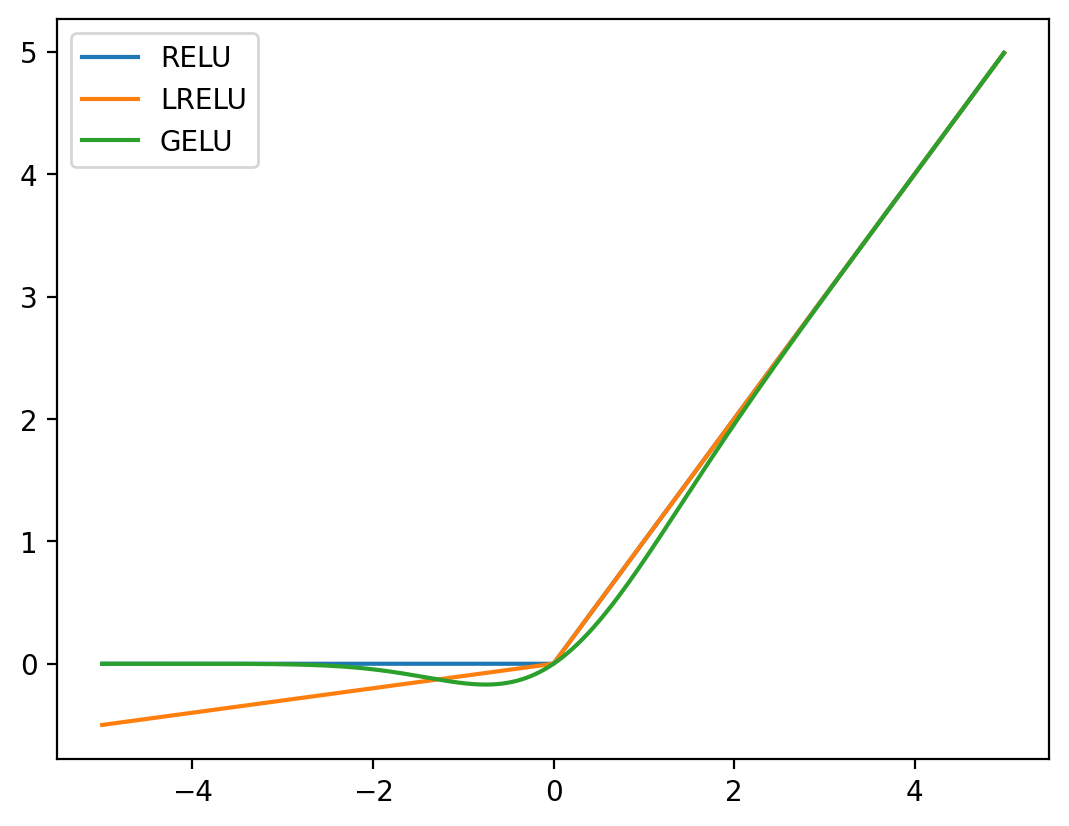

In [18]:
x = np.arange(-5, 5, 0.01)
plt.plot(x, nn.ReLU()(torch.from_numpy(x)))
plt.plot(x, nn.LeakyReLU(negative_slope=0.1)(torch.from_numpy(x)))
plt.plot(x, nn.GELU()(torch.from_numpy(x)))
plt.legend(['RELU', 'LRELU', 'GELU'])

## gradient

- $x\Phi(x)$
    - grad: $\Phi(x)+x\phi(x)$ （$\Phi(x)$: cdf, $\phi(x)$: pdf）
        - $\Phi(x) = \frac{1 + \text{Erf}(x/\sqrt{2})}{2}$

In [19]:
from scipy.special import erf
from scipy.stats import norm
import math
def gelu_grad(x):
    return (1 + erf(x/math.sqrt(2)))/2 + x*norm.pdf(x)

In [20]:
x = torch.tensor([1., 2., 3.], requires_grad=True)
z = nn.GELU()(x).sum()
z.backward()
x.grad

tensor([1.0833, 1.0852, 1.0119])

In [13]:
gelu_grad(x.detach().numpy())

array([1.08331544, 1.08523179, 1.01194562])

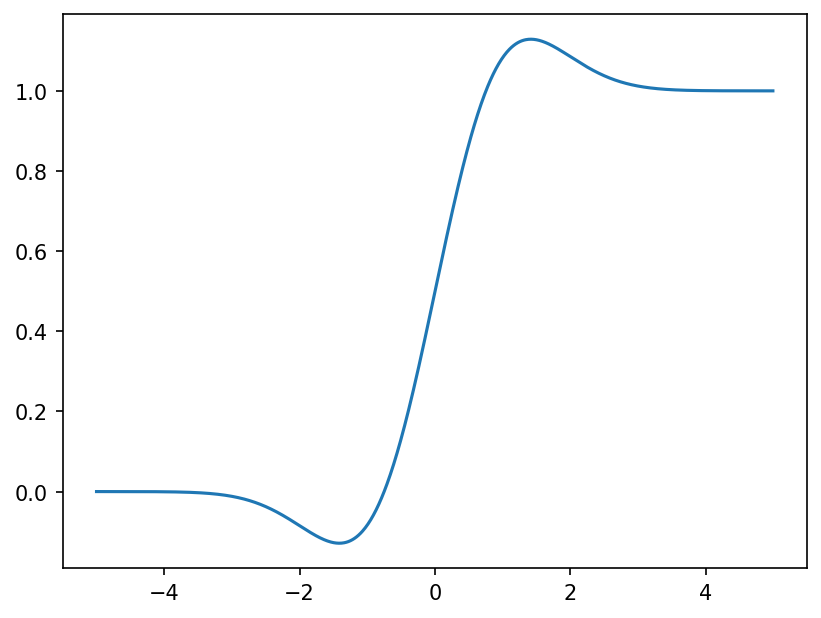

In [14]:
x = np.arange(-5, 5, .01)
plt.plot(x, gelu_grad(x))